# Abberation
Looks at modelling an achromatic lens and optimises it for a given focal length. The achromatic lens is essentially two lenses composed of different materials with different refractive properties. This enables the lens to limit the effects of chromatic abberation.

In [7]:
%matplotlib widget
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display

from tracing import PyTrace, PyRay, PyRefract_Plane, PyRefract_Sph, PyCC_Wrap

plt.style.use('dark_background')

mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rc('font', size=14)

In [8]:
class Doublet(PyCC_Wrap):
    def __init__(self, wavelength) -> None:
        comps = []

        # Good 
        # R_left = 60.0
        # R_mid = 32.0
        # R_right = 85.0

        R_left = 60.0
        R_mid = 32.0
        R_right = 85.0

        centre = np.zeros(2)
        R_lens = 20.0
        self._R_lens = R_lens
        d = 0.0

        # sellmeier Eq coefficients of first and second parts
        # C parameters are in units micrometers^2
        # First is BK7 crown glass
        self._left_refr_param = {
            'B': np.array([1.03961212, 0.231792344, 1.01046945]),
            'C': np.array([6.00069867e-3, 2.00179144e-2, 103.560653])
        }

        # SF2 Flint glass https://refractiveindex.info/?shelf=glass&book=SCHOTT-SF&page=SF2
        self._right_refr_param = {
            'B': np.array([1.40301821, 0.231767504, 0.939056586]),
            'C': np.array([0.0105795466, 0.0493226978, 112.405955])
        }

        n1 = self.sellmeier_eq(wavelength, **self._left_refr_param)
        n2 = self.sellmeier_eq(wavelength, **self._right_refr_param)

        # left arc      
        param = self._create_arc_param(True, centre, R_lens, R_left, R_left, d, n1, n_out=1.0)
        self._left_arc = PyRefract_Sph(**param)
        comps.append(self._left_arc)

        # Middle arc
        param = self._create_arc_param(False, centre, R_lens, R_mid, R_mid, d, n1, n_out=n2)
        self._middle_arc = PyRefract_Sph(**param)
        comps.append(self._middle_arc)

        param = self._create_arc_param(False, np.array([10.0, 0.0]), R_lens, R_right, R_right, d, n2, n_out=1.0)
        self._right_arc = PyRefract_Sph(**param)

        comps.append(self._right_arc)

        super().__init__(comps)

    def _comp_arc_centre(self, left, lens_centre, R_lens, R1, R2, d, n_in, n_out):
        """Returns the centre of the arc"""
        ans = lens_centre.copy()

        R = R1 if left else R2
        lft = 1 if left else -1

        ans[0] += lft *( np.sign(R) * np.sqrt(R**2 - R_lens**2) - d/2)

        return ans

    def _comp_arc_angles(self, left, lens_centre, R_lens, R1, R2, d, n_in, n_out):
        """Returns the angles of the arc"""

        R = R1 if left else R2
        lft = 1 if left else -1

        ang = np.arcsin(np.abs(R_lens / R))

        start, end = -ang, ang

        if lft * R >= R_lens:
            start += np.pi
            end += np.pi

        return (start, end)

    def _comp_arc_refr_ind(self, left, lens_centre, R_lens, R1, R2, d, n_in, n_out):
        """Returns refractive indices n_in and n_out"""

        R = R1 if left else R2

        # Convex arc
        if R >= R_lens:
            return (n_in, n_out)

        return (n_out, n_in)

    def _create_arc_param(self, left, lens_centre, R_lens, R1, R2, d, n_in, n_out):
        """Returns a dictionary of params for creating the left arc"""

        param = dict()

        param['centre'] = self._comp_arc_centre(left, lens_centre, R_lens, R1, R2, d, n_in, n_out)

        param['R'] = np.abs(R1 if left else R2)

        param["start"], param['end'] = self._comp_arc_angles(left, lens_centre, R_lens, R1, R2, d, n_in, n_out)

        param['n_in'], param['n_out'] = self._comp_arc_refr_ind(left, lens_centre, R_lens, R1, R2, d, n_in, n_out)

        return param

    def sellmeier_eq(self, lamd, B, C):
        """
        Computes the refractive index using the Sellmeier equation.
        C should use units of micrometers^2
        """
        lsq = lamd**2

        total = 1.0 + np.sum(B*lsq/(lsq-C))

        return np.sqrt(total)

    def update_refr_ind(self, new_wavelength):
        """Updates the refractive index """

        n1 = self.sellmeier_eq(new_wavelength, **self._left_refr_param)
        n2 = self.sellmeier_eq(new_wavelength, **self._right_refr_param)

        # left arc
        self._left_arc.n_in = n1

        # right arc
        self._middle_arc.n_in = n1
        self._middle_arc.n_out = n2

        # Right arc
        self._right_arc.n_in = n2

    def update_R_right(self, new_r):
        """Updates the radius of curvature on the right"""

        param = self._create_arc_param(False, np.array([10.0, 0.0]), self._R_lens, new_r, new_r, 0.0, 1.0, 1.0)

        self._right_arc.centre = param['centre']
        self._right_arc.R = param['R']
        self._right_arc.update_start_end(param['start'], param['end'])
        
    def update_R_mid(self, new_r):
        param = self._create_arc_param(False, np.zeros(2), self._R_lens, new_r, new_r, 0.0, 1.0, 1.0)

        self._middle_arc.centre = param['centre']
        self._middle_arc.R = param['R']
        self._middle_arc.update_start_end(param['start'], param['end'])

In [9]:
# This is useful as the plotting routine returns a nested list with the leaves
# corresponding to the plotting data
def crawl(lst):
    """Crawls a nested list and yields none-list items"""
    
    if isinstance(lst, list):  # If lst is a list, we want to crawl its elements
        for elem in lst:
            yield from crawl(elem)
    else:
        yield lst

def extend_to_axis(pos):
    """Extends the as position of the ray so last point is on axis"""

    ans = pos.copy()

    grad = np.gradient(pos[-2:, 1], pos[-2:, 0])[0]

    # x_intercept = x_1 - y_1/grad
    ans[-1, 0] = pos[-2, 0] - pos[-2, 1] / grad
    ans[-1, 1] = 0.0

    return ans


In [10]:
doub = Doublet(0.5)

def plot(y, wavelengths):
    """Computes focal point for a ray at y"""

    sol = np.empty_like(wavelengths)
    
    for ind, w in enumerate(wavelengths):
        doub.update_refr_ind(w)

        r = PyRay(np.array([-5.0, y]), np.array([1.0, 0.0]))

        PyTrace([doub], [r], n=4)

        # Add position data
        pos = r.plot()
        
        #grad = np.gradient(pos[-2:, 1], pos[-2:, 0])[0]
        x1, y1 = pos[-2]
        x2, y2 = pos[-1]
        
        grad = (y2-y1) / (x2-x1)

        sol[ind] = x1 - y1 / grad

    return sol


interactive(children=(FloatSlider(value=0.5, description='y', max=19.0, min=0.1, step=0.2), IntSlider(value=39…

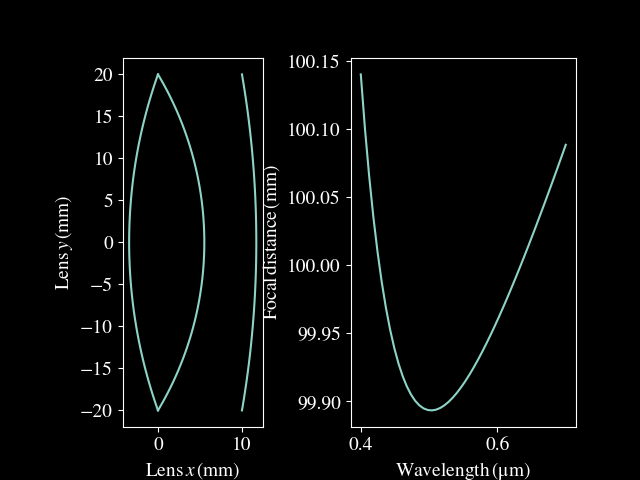

In [19]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_aspect('equal')
ax1.set_xlabel("$\mathrm{Lens} \, x \, (\mathrm{mm})$")
ax1.set_ylabel("$\mathrm{Lens} \, y \, (\mathrm{mm})$")

comp_lines = []

# Plot components
for sub_comp in crawl(doub.plot()):
    c_x, c_y = sub_comp.T

    line, = ax1.plot(c_x, c_y, color="C0")

    comp_lines.append(line)
        
# Plot focus
wav = np.linspace(0.4, 0.7, 50)

focus = plot(5, wav)
focus_line, = ax2.plot(wav, focus)

ax2.set_xlabel("$\mathrm{Wavelength} \, (\mathrm{\mu m})$")
ax2.set_ylabel("$\mathrm{Focal} \, \mathrm{distance} \, (\mathrm{mm})$")

def event_handler(y, R_mid, R_right):
    
    doub.update_R_mid(R_mid)
    doub.update_R_right(R_right)
    
    # Update lens shape first
    for sub_comp, line in zip(crawl(doub.plot()), comp_lines):
        c_x, c_y = sub_comp.T

        line.set_xdata(c_x)
        line.set_ydata(c_y)
        
        
    ax1.relim()
    ax1.autoscale_view()
    
    # Update the focus point 
    new_data = plot(y=y, wavelengths=wav)

    focus_line.set_ydata(new_data)
    
    ax2.relim()
    ax2.autoscale_view()
    
    fig.canvas.draw_idle()

interact(event_handler, 
         y=widgets.FloatSlider(min=0.1, max=19.0, step=0.2, value=0.5),
         R_mid=widgets.IntSlider(min=24, max=100, step=1, value=39),
         R_right=widgets.IntSlider(min=21, max=120, step=1, value=118));

## Optmisation
Here we use Scipy.Optimize to achive a focal length of 100 mm. We consider a ray starting off 0.5 millimetres off axis. 

In [12]:
from scipy.optimize import minimize

In [13]:
def min_func(x):
    """Minimisation function"""
    
    # variable arguments must be specified as a single parameter and unpacked
    R_mid, R_right = x
    
    doub.update_R_mid(R_mid)
    doub.update_R_right(R_right)
    
    y = 0.5
    target = 100.0
    
    focus = plot(y=y, wavelengths=wav)
    
    return np.sum((focus - target)**2)

In [14]:
# Let 24 <= R_mid <= 100 & 21 <= R_right <= 120 to avoid intersection
x0 = np.array([30.0, 100.0])

sol = minimize(min_func, x0, bounds=((24, 100), (21, 120)))

In [15]:
sol

      fun: 0.22126327009616242
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.90767386e-05,  7.17870658e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 108
      nit: 22
     njev: 36
   status: 0
  success: True
        x: array([ 38.97414023, 118.03470915])

The focal length for the optimised lens as a function of wavelength and the ray's distance from axis.

In [16]:
doub.update_R_mid(sol['x'][0])
doub.update_R_right(sol['x'][1])

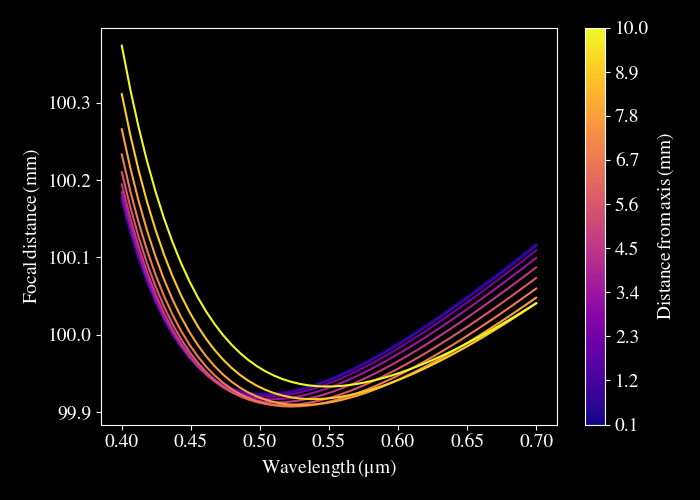

In [17]:
N_rays = 10

y_vals = np.linspace(0.1, 10,N_rays)

fig = plt.figure(figsize=(7, 5))

norm = mpl.colors.Normalize(vmin=np.min(y_vals), vmax=np.max(y_vals))
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.plasma)
cmap.set_array([])

for y in y_vals:
    plt.plot(wav, plot(y, wav), c=cmap.to_rgba(y))
    
cb = fig.colorbar(cmap, ticks=y_vals)

cb.ax.set_ylabel("$\mathrm{Distance} \, \mathrm{from} \, \mathrm{axis} \, (\mathrm{mm})$")
    
plt.xlabel("$\mathrm{Wavelength} \, (\mathrm{\mu m})$")
plt.ylabel("$\mathrm{Focal} \, \mathrm{distance} \, (\mathrm{mm})$")
plt.tight_layout()
plt.show()